# Определение популярности геолокации для размещения банкомата

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


models = {}
results = {}
feature_selection_methods = {}
preprocessor = None


## Загрузка данных

In [2]:
data = pd.read_csv('full_train_data_new.csv')
print(f"Размер данных: {data.shape}")
data.head(3)

Размер данных: (6228, 44)


,Unnamed: 0,latitude,longitude,num_clinics_hospitals,num_touristic_attractions,num_museums,num_theatres,num_schools,num_universities,num_kindergartens,...,town,subtown_district,subtown_subdistrict,street,house,route,metro,airport,target,is_capital
0,0,46.940995,142.738319,0,0,0,0,0,0,0,...,южно-сахалинск,NaN,NaN,улица а.о. емельянова,34,NaN,NaN,NaN,0.01150,0
1,1,46.937353,142.753348,0,0,0,0,0,0,0,...,южно-сахалинск,NaN,NaN,комсомольская улица,259,NaN,NaN,NaN,0.02971,0
2,2,46.959413,142.741113,3,0,0,0,0,0,0,...,южно-сахалинск,NaN,NaN,коммунистический проспект,32,NaN,NaN,NaN,0.00954,0


## Исследование данных

In [3]:
# Основная информация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6228 entries, 0 to 6227
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 6228 non-null   int64  
 1   latitude                   6228 non-null   float64
 2   longitude                  6228 non-null   float64
 3   num_clinics_hospitals      6228 non-null   int64  
 4   num_touristic_attractions  6228 non-null   int64  
 5   num_museums                6228 non-null   int64  
 6   num_theatres               6228 non-null   int64  
 7   num_schools                6228 non-null   int64  
 8   num_universities           6228 non-null   int64  
 9   num_kindergartens          6228 non-null   int64  
 10  num_churches               6228 non-null   int64  
 11  num_shops                  6228 non-null   int64  
 12  num_malls                  6228 non-null   int64  
 13  num_restaurants            6228 non-null   int64

In [4]:
# Статистика числовых признаков
data.describe()


,Unnamed: 0,latitude,longitude,num_clinics_hospitals,num_touristic_attractions,num_museums,num_theatres,num_schools,num_universities,num_kindergartens,...,has_subway,num_atms,num_banks,num_residential_buildings,num_offices,has_bus_station,id,atm_group,target,is_capital
count,6228.00000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,...,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000
mean,3113.50000,54.154035,63.357799,1.195729,0.597142,0.424213,0.203918,0.273764,0.122030,0.326429,...,0.115286,3.927264,3.552505,63.494380,2.969011,0.962428,4422.150048,4413.657193,0.000531,0.098105
std,1798.01307,4.334139,33.019985,1.946383,2.454017,1.312515,0.699976,0.659239,0.458185,0.870752,...,0.319392,5.217635,4.120979,62.248277,9.663663,0.190175,2548.483933,2427.599335,0.085716,0.297481
min,0.00000,42.057080,19.941530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,32.000000,-0.145001,0.000000
25%,1556.75000,52.254406,37.783886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,24.000000,0.000000,1.000000,2226.750000,1942.000000,-0.061271,0.000000
50%,3113.50000,55.082921,48.470443,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,2.000000,51.000000,0.000000,1.000000,4400.500000,5478.000000,-0.015653,0.000000
75%,4670.25000,56.118028,84.949827,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.000000,5.000000,83.000000,2.000000,1.000000,6665.500000,5478.000000,0.039644,0.000000
max,6227.00000,69.491912,158.737224,22.000000,42.000000,19.000000,9.000000,7.000000,10.000000,11.000000,...,1.000000,58.000000,29.000000,958.000000,120.000000,1.000000,8811.000000,8083.000000,0.218608,1.000000


In [5]:
# Проверка пропущенных значений
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

subregional_district        839
subregional_subdistrict    5783
town                         30
subtown_district           5888
subtown_subdistrict        6189
street                      156
house                       112
route                      6216
metro                      6216
airport                    6226
dtype: int64


In [6]:
# Анализ целевой переменной
print(f"Среднее значение: {data['target'].mean():.6f}")
print(f"Стандартное отклонение: {data['target'].std():.6f}")
print(f"Минимум: {data['target'].min():.6f}")
print(f"Максимум: {data['target'].max():.6f}")

Среднее значение: 0.000531
Стандартное отклонение: 0.085716
Минимум: -0.145001
Максимум: 0.218608


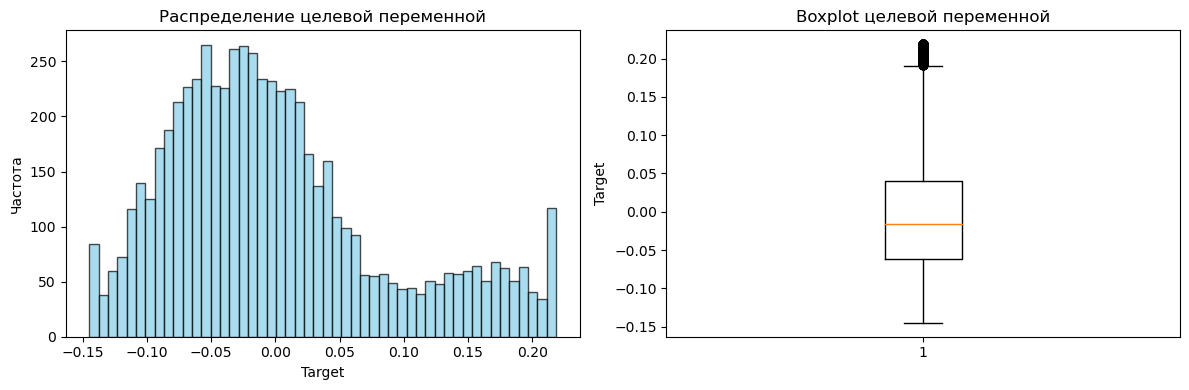

In [7]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(data['target'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение целевой переменной')
plt.xlabel('Target')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.boxplot(data['target'])
plt.title('Boxplot целевой переменной')
plt.ylabel('Target')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Предобработка данных

In [8]:
def preprocess_data():
    global data, X_train, X_test, y_train, y_test, preprocessor
    
    print("\n===== Предобработка данных =====")
    
    # Копия данных для обработки
    df = data.copy()
    
    # Удаление ненужных колонок
    columns_to_drop = ['Unnamed: 0', 'id', 'lat_long', 'address', 'address_rus', 'address_rus_full', 
                      'route', 'metro', 'airport']
    df = df.drop(columns=columns_to_drop, errors='ignore')
    
    # Удаление атрибутов с заполненностью меньше 20%
    print("\nУдаление атрибутов с заполненностью < 20%:")
    columns_to_drop = []
    
    for col in df.columns:
        missing_ratio = df[col].isnull().sum() / len(df)
        if missing_ratio > 0.8:  # Заполненность меньше 20%
            columns_to_drop.append(col)
            print(f"  Удалена колонка {col}")
    
    df = df.drop(columns=columns_to_drop)
    print(f"  Всего удалено колонок: {len(columns_to_drop)}")
    
    # Преобразование atm_group в категориальную переменную
    atm_group_mapping = {
        8083.0: 'Росбанк',
        1022.0: 'АК Барс',
        1942.0: 'Альфабанк',
        3185.5: 'Газпромбанк',
        32.0: 'Райффазен',
        496.5: 'Россельхозбанк',
        5478.0: 'Уралсиб'
    }
    
    if 'atm_group' in df.columns:
        df['atm_group'] = df['atm_group'].map(atm_group_mapping)
        print("  Преобразована колонка atm_group в категориальную")
    
    # Определение числовых и категориальных признаков
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    # Удаление целевой переменной из числовых признаков
    if 'target' in numeric_features:
        numeric_features.remove('target')

    print(f"Числовые признаки: {numeric_features}")
    print(f"Категориальные признаки: {categorical_features}")
    
    # Заполнение пустых значений
    print("\nЗаполнение пустых значений:")
    
    # Для числовых признаков - медиана (более устойчива к выбросам)
    for col in numeric_features:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  {col}: заполнено медианой ({median_val:.2f})")
    
    # Для категориальных признаков - самое частое значение
    for col in categorical_features:
        if df[col].nunique() > 50:  # Если слишком много уникальных значений
            df = df.drop(columns=[col])
            print(f"  Удалена колонка {col} (слишком много уникальных значений)")
        else:
            if df[col].isnull().sum() > 0:
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"  {col}: заполнено модой ('{mode_val}')")
    
    # Обновление списков признаков
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    if 'target' in numeric_features:
        numeric_features.remove('target')
    
    # Разделение на признаки и целевую переменную
    X = df.drop('target', axis=1)
    y = df['target']

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Размер обучающей выборки: {X_train.shape}")
    print(f"Размер тестовой выборки: {X_test.shape}")
    
    # Создание пайплайна для предобработки
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    # Объединение трансформеров
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return X_train, X_test, y_train, y_test


# Получаю списокпризнаков
def get_feature_names():
    global X_train
    
    feature_names = []
    
    # Числовые признаки
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    feature_names.extend(numeric_features)
    
    # Категориальные признаки после OHE
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_features:
        unique_values = X_train[col].unique()
        for val in unique_values:
            feature_names.append(f"{col}_{val}")
    
    return feature_names


# ====================== Отбор признаков ============================
def apply_feature_selection():
    
    global X_train, X_test, y_train, preprocessor, feature_selection_methods
    
    print("\n====== Отбор признаков ======")
    
    # Трансформация данных для отбора признаков
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    # Получение имен признаков после трансформации
    feature_names = get_feature_names()
    
    print(f"Исходное количество признаков: {X_train_transformed.shape[1]}")
    
    # 1. Фильтрационный метод (SelectKBest)
    print("\n1. Фильтрационный метод (SelectKBest):")
    
    # SelectKBest с f_regression
    k_best = SelectKBest(score_func=f_regression, k=min(30, X_train_transformed.shape[1]))
    X_train_kbest = k_best.fit_transform(X_train_transformed, y_train)
    X_test_kbest = k_best.transform(X_test_transformed)
    
    selected_features_kbest = [feature_names[i] for i in k_best.get_support(indices=True)]
    print(f"  SelectKBest (f_regression): выбрано {X_train_kbest.shape[1]} признаков")
    
    feature_selection_methods['SelectKBest'] = {
        'selector': k_best,
        'X_train': X_train_kbest,
        'X_test': X_test_kbest,
        'feature_names': selected_features_kbest
    }
    
    # 2. Оберточный метод (RFE)
    print("\n2. Оберточный метод (RFE):")
    
    # RFE с RandomForest
    rfe = RFE(
        estimator=RandomForestRegressor(n_estimators=50, random_state=42),
        n_features_to_select=min(30, X_train_transformed.shape[1])
    )
    X_train_rfe = rfe.fit_transform(X_train_transformed, y_train)
    X_test_rfe = rfe.transform(X_test_transformed)
    
    selected_features_rfe = [feature_names[i] for i in rfe.get_support(indices=True)]
    print(f"  RFE (RandomForest): выбрано {X_train_rfe.shape[1]} признаков")
    
    feature_selection_methods['RFE'] = {
        'selector': rfe,
        'X_train': X_train_rfe,
        'X_test': X_test_rfe,
        'feature_names': selected_features_rfe
    }
    
#     # 3. PCA (метод главных компонент) (не подошел, результаты неочень)
#     print("\n3. PCA (Метод главных компонент):")
    
#     # PCA
#     n_components = min(30, X_train_transformed.shape[1])
#     pca = PCA(n_components=n_components)
#     X_train_pca = pca.fit_transform(X_train_transformed)
#     X_test_pca = pca.transform(X_test_transformed)
    
#     explained_variance_ratio = pca.explained_variance_ratio_.sum()
#     print(f"  PCA: {n_components} компонент, объяснено {explained_variance_ratio:.3f} дисперсии")
    
#     feature_selection_methods['PCA'] = {
#         'selector': pca,
#         'X_train': X_train_pca,
#         'X_test': X_test_pca,
#         'feature_names': [f'PC_{i+1}' for i in range(n_components)],
#         'explained_variance_ratio': explained_variance_ratio
#     }
    
    return feature_selection_methods




## Обучение моделей

In [9]:
def train_models_on_data(models_and_params, method_data, data_type):
    global X_train, X_test, y_train, y_test, preprocessor, models, results
    
    # Определение данных для обучения
    if method_data is None:
        # Исходные данные
        X_train_data = X_train
        X_test_data = X_test
        current_preprocessor = preprocessor
    else:
        # Данные с отбором признаков
        X_train_data = method_data['X_train']
        X_test_data = method_data['X_test']
        current_preprocessor = method_data['selector']
    
    # Обучение и оценка моделей
    for name, config in models_and_params.items():
        model_name = f"{name}_{data_type}"
        print(f"  Обучение {model_name}...")
        
        # Создание полного пайплайна и адаптация параметров
        if method_data is None:
            # Для исходных данных используем полный пайплайн с препроцессором
            full_pipeline = Pipeline([
                ('preprocessor', current_preprocessor),
                ('regressor', config['model'])
            ])
            params = config['params']
        else:
            # Для данных с отбором признаков используем только регрессор
            # Создаем модель напрямую без пайплайна
            model = config['model']
            # Убираем префикс 'regressor__' для данных с отбором признаков
            params = {}
            for key, value in config['params'].items():
                new_key = key.replace('regressor__', '')
                params[new_key] = value
            
            # Если нет параметров после обработки, создаем пустой словарь
            if not params:
                params = {}
        
        # Если есть параметры для подбора, используем GridSearch
        if params:
            print(f"    Подбор гиперпараметров...")
            
            if method_data is None:
                # Для исходных данных используем пайплайн
                grid_search = GridSearchCV(
                    full_pipeline, 
                    params, 
                    cv=5, 
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=0
                )
                grid_search.fit(X_train_data, y_train)
                best_model = grid_search.best_estimator_
            else:
                # Для данных с отбором признаков используем модель напрямую
                grid_search = GridSearchCV(
                    model, 
                    params, 
                    cv=5, 
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=0
                )
                grid_search.fit(X_train_data, y_train)
                best_model = grid_search.best_estimator_
            
            print(f"    Лучшие параметры: {grid_search.best_params_}")
            
            # Предсказания
            y_pred = best_model.predict(X_test_data)
            
            # Оценка качества
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Сохранение результатов
            models[model_name] = best_model
            results[model_name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'Best_Params': grid_search.best_params_,
                'Data_Type': data_type
            }
            
            print(f"    RMSE: {rmse:.6f}")
            print(f"    MAE: {mae:.6f}")
            print(f"    R²: {r2:.6f}")
            
        else:
            # Для моделей без гиперпараметров (например, Linear Regression)
            if method_data is None:
                full_pipeline.fit(X_train_data, y_train)
                y_pred = full_pipeline.predict(X_test_data)
                final_model = full_pipeline
            else:
                model.fit(X_train_data, y_train)
                y_pred = model.predict(X_test_data)
                final_model = model
            
            # Оценка качества
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Сохранение результатов
            models[model_name] = final_model
            results[model_name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'Best_Params': 'No hyperparameters',
                'Data_Type': data_type
            }
            
            print(f"    RMSE: {rmse:.6f}")
            print(f"    MAE: {mae:.6f}")
            print(f"    R²: {r2:.6f}")

            
            
def train_all_models_with_gridsearch():
    global feature_selection_methods
    
    print("\n=== Обучение всех моделей с подбором гиперпараметров ===")
    
    # Определение всех моделей и их параметров для GridSearch
    models_and_params = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}  # Линейная регрессия не имеет гиперпараметров для подбора
        },
        'Decision Tree': {
            'model': DecisionTreeRegressor(random_state=42),
            'params': {
                'regressor__max_depth': [5, 10, 15, 20],
                'regressor__min_samples_split': [2, 5, 10],
                'regressor__min_samples_leaf': [1, 2, 4]
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'regressor__n_estimators': [50, 100, 200],
                'regressor__max_depth': [10, 15, 20],
                'regressor__min_samples_split': [2, 5, 10]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'regressor__n_estimators': [50, 100, 200],
                'regressor__max_depth': [3, 5, 8],
                'regressor__learning_rate': [0.01, 0.1, 0.2]
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
            'params': {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [6, 8, 10],
                'regressor__learning_rate': [0.05, 0.1, 0.15]
            }
        },
        'LightGBM': {
            'model': lgb.LGBMRegressor(random_state=42, verbose=-1),
            'params': {
                'regressor__n_estimators': [100, 200, 300],
                'regressor__max_depth': [6, 8, 10],
                'regressor__learning_rate': [0.05, 0.1, 0.15]
            }
        },
        'CatBoost': {
            'model': CatBoostRegressor(random_state=42, verbose=False),
            'params': {
                'regressor__iterations': [100, 200, 300],
                'regressor__depth': [6, 8, 10],
                'regressor__learning_rate': [0.05, 0.1, 0.15]
            }
        }
    }
    
    
    # Обучение моделей на исходных данных
    print("\nОбучение на исходных данных:")
    train_models_on_data(models_and_params, None, "Original")
    
    # Обучение моделей на данных с отбором признаков
    for method_name, method_data in feature_selection_methods.items():
        print(f"\nОбучение на данных с {method_name}:")
        train_models_on_data(models_and_params, method_data, method_name)

## Сравнение всех моделей

In [10]:
def compare_all_models():
    global results, models
    
    print("\n====Сравнение всех моделей ===")
    
    # Создание DataFrame с результатами
    results_df = pd.DataFrame(results).T
    
    # Убеждаемся, что метрики являются числовыми
    numeric_columns = ['RMSE', 'MAE', 'R2']
    for col in numeric_columns:
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')
    
#     print(results_df.round(6))
    
    # Сохранение результатов в Excel файл
    try:
        filename = f'model_comparison_results_{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}.xlsx'
        results_df.round(6).to_excel(filename, sheet_name='Все модели', index=True)
        print(f"\nРезультаты сохранены в файл: {filename}")
        
    except Exception as e:
        print(f"Ошибка при сохранении в Excel: {e}")
    
    # Определение лучшей модели
    best_model_name = results_df['R2'].idxmax()
    best_model = models[best_model_name]
    
    print(f"\nЛучшая модель: {best_model_name}")
    print(f"R²: {results_df.loc[best_model_name, 'R2']:.6f}")
    print(f"RMSE: {results_df.loc[best_model_name, 'RMSE']:.6f}")
    print(f"MAE: {results_df.loc[best_model_name, 'MAE']:.6f}")
    print(f"Тип данных: {results_df.loc[best_model_name, 'Data_Type']}")
    print(f"Лучшие параметры: {results_df.loc[best_model_name, 'Best_Params']}")
    
    return best_model_name, best_model



# ===================== Анализ важности признаков для лучшей модели =============================
def feature_importance_analysis(best_model_name):
    global models, results, X_train, preprocessor, feature_selection_methods
    
    print(f"\n==== Анализ важности признаков ({best_model_name}) =====")
    
    best_model = models[best_model_name]
    best_result = results[best_model_name]
    
    # Получение трансформированных признаков
    if best_result['Data_Type'] == 'Original':
        X_train_transformed = preprocessor.transform(X_train)
        feature_names = get_feature_names()
    else:
        # Для моделей с отбором признаков
        method_data = feature_selection_methods[best_result['Data_Type']]
        X_train_transformed = method_data['X_train']
        feature_names = method_data['feature_names']
    
    # Получение важности признаков
    if hasattr(best_model, 'named_steps') and hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
        # Для пайплайнов (исходные данные)
        importances = best_model.named_steps['regressor'].feature_importances_
    elif hasattr(best_model, 'feature_importances_'):
        # Для моделей напрямую (данные с отбором признаков)
        importances = best_model.feature_importances_
    else:
        print("Модель не поддерживает анализ важности признаков")
        return
    
    # Создание DataFrame с важностью признаков
    feature_importance_df = pd.DataFrame({
        'feature': feature_names[:len(importances)],
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Топ-10 важных признаков:")
    print(feature_importance_df.head(10))
    
    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    top_features = feature_importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-10 важных признаков ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()



=== Начало анализа ===

===== Предобработка данных =====

Удаление атрибутов с заполненностью < 20%:
  Удалена колонка subregional_subdistrict
  Удалена колонка subtown_district
  Удалена колонка subtown_subdistrict
  Всего удалено колонок: 3
  Преобразована колонка atm_group в категориальную
Числовые признаки: ['latitude', 'longitude', 'num_clinics_hospitals', 'num_touristic_attractions', 'num_museums', 'num_theatres', 'num_schools', 'num_universities', 'num_kindergartens', 'num_churches', 'num_shops', 'num_malls', 'num_restaurants', 'num_cinemas', 'num_fitness_centres', 'has_airport', 'has_train_station', 'has_subway', 'num_atms', 'num_banks', 'num_residential_buildings', 'num_offices', 'has_bus_station', 'is_capital']
Категориальные признаки: ['atm_group', 'federal_district', 'region', 'subregional_district', 'town', 'street', 'house']

Заполнение пустых значений:
  Удалена колонка region (слишком много уникальных значений)
  Удалена колонка subregional_district (слишком много уник

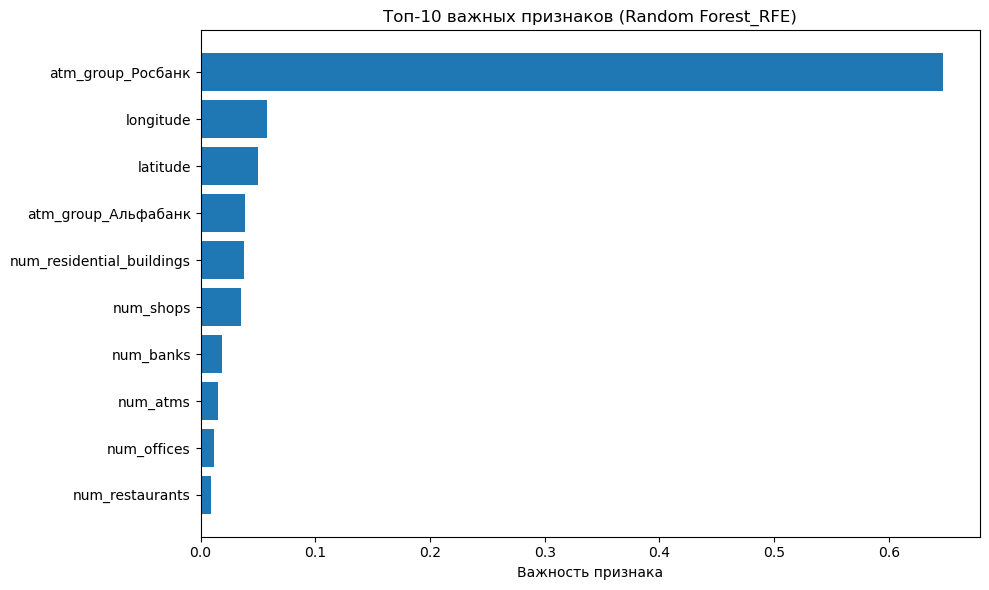


=== Анализ завершен ===
Лучшая модель: Random Forest_RFE


In [11]:
def run_atm_analysis():
    
    print("\n=== Начало анализа ===") 
    
    # Предобработка данных
    preprocess_data()
    
    # Применение методов отбора признаков
    apply_feature_selection()
    
    # Обучение всех моделей с подбором гиперпараметров
    train_all_models_with_gridsearch()
    
    # Сравнение всех моделей
    best_model_name, best_model = compare_all_models()
    
    # Анализ важности признаков
    feature_importance_analysis(best_model_name)
    
    print("\n=== Анализ завершен ===")
    print(f"Лучшая модель: {best_model_name}")
    
    return best_model_name, best_model

best_model_name, best_model = run_atm_analysis()
